# Parsing Table Data into Graphs

In [1]:
import pandas as pd

df1 = pd.read_csv('data/activity_list.csv')
df1.head()

,ID,Activity,Optimistic,Normal,Pessimistic
0,1,A,2,4,6
1,2,B,3,5,9
2,3,C,4,5,7
3,4,D,4,6,10
4,5,E,4,5,7


In [2]:
df1['Expected'] = (df1['Optimistic'] + 4*df1['Normal'] + df1['Pessimistic']) / 6.0
df1.head()

,ID,Activity,Optimistic,Normal,Pessimistic,Expected
0,1,A,2,4,6,4.000000
1,2,B,3,5,9,5.333333
2,3,C,4,5,7,5.166667
3,4,D,4,6,10,6.333333
4,5,E,4,5,7,5.166667


In [3]:
df2 = pd.read_csv('data/edge_list.csv')
df2.head()

,ID,Parent,Child
0,1,1,3
1,2,1,4
2,3,2,5
3,4,3,5
4,5,4,6


In [4]:
import networkx as nx

G = nx.DiGraph()

for index, row in df1.iterrows():
    G.add_node(row['Activity'])
    G.node[row['Activity']]['Optimistic'] = row['Optimistic']
    G.node[row['Activity']]['Normal'] = row['Normal']
    G.node[row['Activity']]['Pessimistic'] = row['Pessimistic']
    G.node[row['Activity']]['Expected'] = row['Expected']
    
dict(G.nodes(data=True))

{'A': {'Optimistic': 2, 'Normal': 4, 'Pessimistic': 6, 'Expected': 4.0},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.333333333333333},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667},
 'D': {'Optimistic': 4,
  'Normal': 6,
  'Pessimistic': 10,
  'Expected': 6.333333333333333},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667},
 'F': {'Optimistic': 3, 'Normal': 4, 'Pessimistic': 8, 'Expected': 4.5},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.166666666666667}}

In [5]:
for index, row in df2.iterrows():
    u = df1.at[row['Parent']-1, 'Activity']
    v = df1.at[row['Child']-1, 'Activity']
    G.add_edge(u, v)
    
G.edges()

OutEdgeView([('A', 'C'), ('A', 'D'), ('B', 'E'), ('C', 'E'), ('D', 'F'), ('E', 'G')])

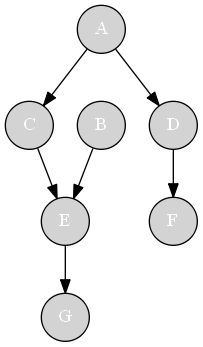

In [6]:
import networkx.drawing.nx_pydot as pdt
from IPython.display import Image, display

def display_graph(G):
    A = pdt.to_pydot(G)
    for i, node in enumerate(A.get_nodes()):
        node.set_shape('circle')
        node.set_style('filled')
        node.set_fontcolor('#FFFFFF')
    plt = Image(A.create_png())
    display(plt)
    
display_graph(G)

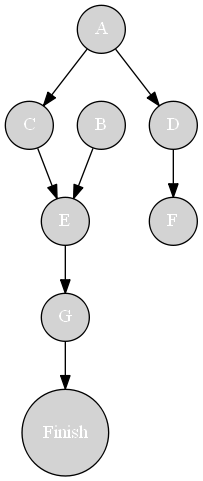

In [7]:
def add_finish_node(G, leaf_nodes=None, start_node=None):
    
    if G.has_node('Finish'):
        G.remove_node('Finish')
    
    if leaf_nodes is None and start_node is None:
        if G.has_node('Start'):
            leaf_nodes = [node for node in nx.descendants(G, 'Start') if not list(G.successors(node))]
        else:
            leaf_nodes = [node for node in G.nodes() if not list(G.successors(node))]
    elif start_node is not None and leaf_nodes is None:
        leaf_nodes = [node for node in nx.descendants(G, start_node) if not list(G.successors(node))]
    elif start_node is not None and leaf_nodes is not None:
        raise ValueError("Use either \'leaf_nodes\' or \'start_node\' but not both")
        
    G.add_node('Finish')
    G.node['Finish']['Optimistic'] = 0
    G.node['Finish']['Normal'] = 0
    G.node['Finish']['Pessimistic'] = 0
    G.node['Finish']['Expected'] = 0
    for node in leaf_nodes:
        G.add_edge(node, 'Finish')
    return G
        
G = add_finish_node(G, leaf_nodes=['G'])
display_graph(G)

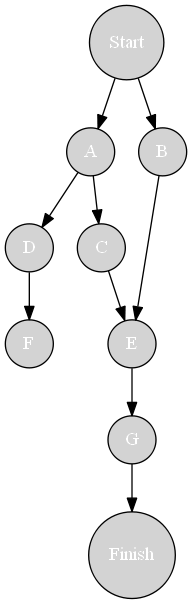

In [8]:
def add_start_node(G, root_nodes=None, finish_node=None):
    
    if G.has_node('Start'):
        G.remove_node('Start')
    
    if root_nodes is None and finish_node is None:
        if G.has_node('Finish'):
            root_nodes = [node for node in nx.ancestors(G, 'Finish') if not list(G.predecessors(node))]
        else:
            root_nodes = [node for node in G.nodes() if not list(G.predecessors(node))]
    elif finish_node is not None and root_nodes is None:
        root_nodes = [node for node in nx.ancestors(G, finish_node) if not list(G.predecessors(node))]
    elif finish_node is not None and root_nodes is not None:
        raise ValueError("Use either \'root_nodes\' or \'finish_node\' but not both")
    
    G.add_node('Start')
    G.node['Start']['Optimistic'] = 0
    G.node['Start']['Normal'] = 0
    G.node['Start']['Pessimistic'] = 0
    G.node['Start']['Expected'] = 0
    for node in root_nodes:
        G.add_edge('Start', node)
    return G

G = add_start_node(G)
display_graph(G)

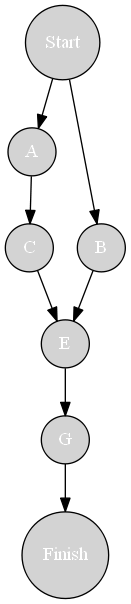

In [9]:
nodes = [node for node in nx.ancestors(G, 'Finish') if node in nx.descendants(G, 'Start')]
nodes.extend(['Start', 'Finish'])
H = G.subgraph(nodes)
display_graph(H)

In [10]:
for node in nx.topological_sort(H):
    parents = list(H.predecessors(node))
    if not parents:
        H.node[node]['Early Start'] = 0
    else:
        H.node[node]['Early Start'] = max(H.node[x]['Early Finish'] for x in parents)
    H.node[node]['Early Finish'] = H.node[node]['Early Start'] + H.node[node]['Expected']
    
dict(H.nodes(data=True))    

{'A': {'Optimistic': 2,
  'Normal': 4,
  'Pessimistic': 6,
  'Expected': 4.0,
  'Early Start': 0,
  'Early Finish': 4.0},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.333333333333333,
  'Early Start': 0,
  'Early Finish': 5.333333333333333},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667,
  'Early Start': 4.0,
  'Early Finish': 9.166666666666668},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667,
  'Early Start': 9.166666666666668,
  'Early Finish': 14.333333333333336},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.166666666666667,
  'Early Start': 14.333333333333336,
  'Early Finish': 19.500000000000004},
 'Finish': {'Optimistic': 0,
  'Normal': 0,
  'Pessimistic': 0,
  'Expected': 0,
  'Early Start': 19.500000000000004,
  'Early Finish': 19.500000000000004},
 'Start': {'Optimistic': 0,
  'Normal': 0,
  'Pessimistic': 0,
  'Expected': 0,
  'E

In [11]:
for node in list(reversed(list(nx.topological_sort(H)))):
    children = list(H.successors(node))
    if not children:
        H.node[node]['Late Finish'] = H.node[node]['Early Finish']
    else:
        H.node[node]['Late Finish'] = min(H.node[x]['Late Start'] for x in children)
    H.node[node]['Late Start'] = H.node[node]['Late Finish'] - H.node[node]['Expected']
    
dict(H.nodes(data=True))

{'A': {'Optimistic': 2,
  'Normal': 4,
  'Pessimistic': 6,
  'Expected': 4.0,
  'Early Start': 0,
  'Early Finish': 4.0,
  'Late Finish': 4.000000000000001,
  'Late Start': 8.881784197001252e-16},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.333333333333333,
  'Early Start': 0,
  'Early Finish': 5.333333333333333,
  'Late Finish': 9.166666666666668,
  'Late Start': 3.833333333333335},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667,
  'Early Start': 4.0,
  'Early Finish': 9.166666666666668,
  'Late Finish': 9.166666666666668,
  'Late Start': 4.000000000000001},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.166666666666667,
  'Early Start': 9.166666666666668,
  'Early Finish': 14.333333333333336,
  'Late Finish': 14.333333333333336,
  'Late Start': 9.166666666666668},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.166666666666667,
  'Early Start': 14.33333333

In [13]:
for node in H.nodes():
    H.node[node]['Slack'] = H.node[node]['Late Finish'] - H.node[node]['Early Finish']
    
[node for node in H.nodes() if H.node[node]['Slack'] < 0.01]

['A', 'C', 'E', 'G', 'Finish', 'Start']

In [14]:
max(nx.all_simple_paths(G, source='Start', target='Finish'), key=lambda path: sum(H.node[node]['Expected'] for node in path))

['Start', 'A', 'C', 'E', 'G', 'Finish']